# Inference procedure: 3PM-Noise2Void

In [1]:
# Jupyter-notebook magic

# For the matplotlib 
%matplotlib inline
# For reload functions explicitly
%load_ext autoreload
%autoreload 2

In [2]:
# Imports

## Add the modules to the system path
import os
import sys
sys.path.append(os.path.join(".."))

## Libs
import numpy as np
import glob
import tifffile
import torch
from torchvision import transforms
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
cudnn.fastest = True
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

## Own modules
import utils
from transformations import PercentileNormalize3D, PercentileDenormalize3D, ZCrop3D, ToTensor3D, ToNumpy3D
from dataset import InferenceDataset3D
from network import Noise2NoiseUNet3D

C:\Users\PrevedelGroup\.conda\envs\Deep3P_Denoising\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Channel selection

In [3]:
# Select here, if mGFP or THG should be denoised #
denoise_mGFP = True
#************************************************#

## Select 3PM-N2V or 3P-N2V2

In [ ]:
# Select whether 3PM-N2V or 3PM-N2V2 should be used #
use_N2V2_setup = True
#***************************************************#

## Folder Structures

In [ ]:
# Enter the store path for the results and raw file here #
path_results = os.path.join("..")
if use_N2V2_setup:
    path_results = os.path.join(path_results, "results_3PM-N2V2")
else:
    path_results = os.path.join(path_results, "results_3PM-N2V")
if denoise_mGFP:
    path_results = path_results+"_mGFP"
else:
    path_results = path_results+"_THG"

path_dataset = os.path.join("..", "data", "3PM-N2V")
#********************************************************#

In [5]:
# Create a folder for the inference based on the results folder

# Make a folder to store the inference
inference_folder = os.path.join(path_results, 'inference_results')
os.makedirs(inference_folder, exist_ok=True)

# Define path to the checkpoint folder
checkpoint_folder = os.path.join(path_results, 'checkpoints')

## Load raw data

In [6]:
## Load image stack for inference
filenames = glob.glob(os.path.join(path_dataset, "*-train.tif"))
print("Following file will be denoised:  ", filenames[0])

file = tifffile.imread(filenames[0])

if denoise_mGFP:
    file = file[:,0].squeeze()
else:
    file = file[:,1].squeeze()

Following file will be denoised:   ..\data\3PM-N2V\RD5_3P_data-train.tif


## Parameters

### Inference parameters

In [7]:
# Select the inference parameters #

# Z size of the input substack (should minimum the same as in training)
z_input_size = 16
# Shows the overlap
stride_to_size_ratio=2
# Crop top and bottom z-slices to prevent artefacts
z_crop_width = (2, 2)

#********************************#

### Parameters and function needed for inference

In [9]:
# datatype of the original data
data_type = file.dtype
print("The data type of the raw data is:   ", data_type)

# calculate the norm. factors
print("\nThe norm. factors are: ")
min_img, max_img = utils.calc_normfactors(file)

# check if GPU is accessable
if torch.cuda.is_available():
    print("\nGPU will be used.")
    device = torch.device("cuda:0")
else:
    print("\nCPU will be used.")
    device = torch.device("cpu")

The data type of the raw data is:    uint16

The norm. factors are: 
Minimum: 0.5016708628976883	 Maximum: 0.5051346608682383

GPU will be used.


In [10]:
## Data handling
# Use the right back-conversation
if data_type == np.uint16:
    norm_func = utils.NormFloat2UInt16(percent=1.0)
elif data_type == np.int16:
    norm_func = utils.NormFloat2Int16(percent=1.0)
else:
    norm_func = utils.NormFloat2UInt8(percent=1.0)

## Transformation
transform = transforms.Compose([PercentileNormalize3D(mi=min_img, ma=max_img),
                                ToTensor3D()
                                ])
transform_inv = transforms.Compose([ToNumpy3D(),
                                    ZCrop3D(z_crop_width),
                                    PercentileDenormalize3D(mi=min_img, ma=max_img),
                                    norm_func
                                   ])
## Inference Dataset and Dataloader
inference_dataset = InferenceDataset3D(file, z_crop_width, z_input_size, stride_to_size_ratio, transform=transform)
inference_loader = torch.utils.data.DataLoader(inference_dataset, batch_size=1, shuffle=False, num_workers=0)

In [11]:
## Initialize the inference data and for sanity check the input data
size_prediction = inference_dataset.get_output_size()

input_data = np.empty(size_prediction, dtype=np.float64)
inference_data = np.empty(size_prediction, dtype=np.float64)

In [12]:
## Load pretrained model
net = Noise2NoiseUNet3D(in_channels = 1,
                        out_channels = 1,                                                
                        is_N2V2_setup=use_N2V2_setup,
                        final_sigmoid = True).to(device)

net, st_epoch = utils.load(checkpoint_folder, net, device)

Loaded 300th network


## Inference

In [13]:
## Apply the model
with torch.no_grad():
    net.eval()

    print(f'Number of batches: {len(inference_loader)}')

    # Going through whole dataset
    for batch, data in enumerate(tqdm(inference_loader)):

        input, current_index, norm_factors = data
        cropped_current_index = current_index.squeeze() 
        cropped_norm_factors = norm_factors.squeeze() 
        
        input = input.to(device)
        # forward net
        output = net(input)
        ## transform data back
        inference_data[cropped_current_index] += cropped_norm_factors.numpy()[..., None, None] * transform_inv(output).squeeze()
        input_data[cropped_current_index] += cropped_norm_factors.numpy()[..., None, None] * transform_inv(input).squeeze()

# Crop the data to its original size
z_begin, z_end = inference_dataset.get_cropping_indices()
inference_data = inference_data[z_begin:z_end]
input_data = input_data[z_begin:z_end]

Number of batches: 41


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]


## Show inference result

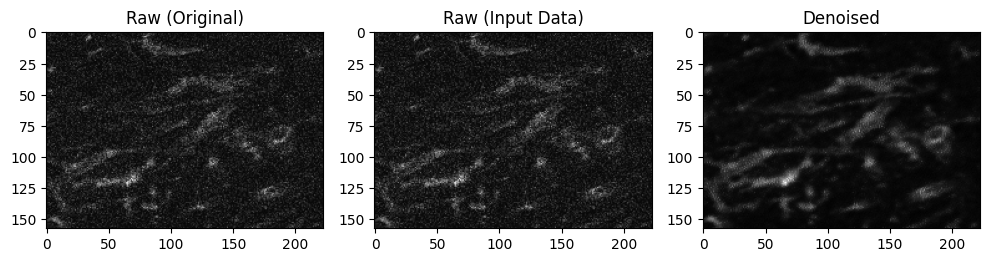

In [15]:
plt.figure(figsize=(10,30))

ind = file.shape[0]//2

plt.subplot(131)
plt.title("Raw (Original)")
plt.imshow(file[ind], cmap="gray")

plt.subplot(132)
plt.title("Raw (Input Data)")
plt.imshow(input_data[ind], cmap="gray")

plt.subplot(133)
plt.title("Denoised")
plt.imshow(inference_data[ind], cmap="gray")

plt.tight_layout()
plt.show()

## Save the inference

In [16]:
store_name_inference = os.path.join(inference_folder, filenames[0].split(os.sep)[-1][:-4] + '-denoised.tif')
tifffile.imwrite(store_name_inference, np.rint(inference_data).astype(data_type))

In [17]:
store_name_input = os.path.join(inference_folder, filenames[0].split(os.sep)[-1][:-4] + '-input.tif')
tifffile.imwrite(store_name_input, np.rint(inference_data).astype(data_type))